In [1]:
import os, math
import numpy as np
import pandas as pd
import seaborn as sns
import helpers
import xgboost as xgb

%matplotlib inline
import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn import svm
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import log_loss
from models import *

//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
//anaconda/envs/cancer/lib/python3.6/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarnin

In [2]:
text, variants = helpers.get_training('./input/training_variants', './input/training_text')
train_full = variants.merge(text, how='inner', on='ID')

#this is 10% of the labeled data
text, variants = helpers.get_test('./input/training_variants', './input/training_text')
test_full = variants.merge(text, how='inner', on='ID')

print(train_full.shape)
print(test_full.shape)

//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-03 23:23:43.004187. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


(2656, 5)
(665, 5)


Use TF-IDF to Vectorize the texts， a feature selector, then SVM one-vs-all classification. 

In [3]:
#pl1 = GeneSvm().fit_feature(train_full)
pl2 = TfidfSvm().fit_feature(train_full)

this is a tfidf+svm model


//anaconda/envs/cancer/lib/python3.6/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2017-08-03 23:23:43.005508. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [4]:
#X_train = np.concatenate((GeneSvm().get_feature(pl1, train_full), TfidfSvm().get_feature(pl2, train_full).todense()), axis=1)
X_train = TfidfSvm().get_feature(pl2, train_full).todense()

this is a tfidf+svm model


In [5]:
#X_test = np.concatenate((GeneSvm().get_feature(pl1, test_full), TfidfSvm().get_feature(pl2, test_full).todense()), axis=1)
X_test = TfidfSvm().get_feature(pl2, test_full).todense()

this is a tfidf+svm model


In [6]:
y_train = train_full['Class']-1
y_test = test_full['Class']-1

In [14]:

params = {
        'eta': 0.03333,
        'max_depth': 10,
        'min_child_weight': 1,
        'gamma': 5,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'seed': 0,
        'silent': True
    }

watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)

[0]	train-mlogloss:2.12133	valid-mlogloss:2.14389
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:0.974358	valid-mlogloss:1.297
[100]	train-mlogloss:0.802407	valid-mlogloss:1.16374
[150]	train-mlogloss:0.777021	valid-mlogloss:1.13946
[200]	train-mlogloss:0.768537	valid-mlogloss:1.13077
[250]	train-mlogloss:0.765555	valid-mlogloss:1.1277
[300]	train-mlogloss:0.763018	valid-mlogloss:1.12508
[350]	train-mlogloss:0.762147	valid-mlogloss:1.12463
[400]	train-mlogloss:0.761876	valid-mlogloss:1.12439
[450]	train-mlogloss:0.761875	valid-mlogloss:1.12434
[500]	train-mlogloss:0.761875	valid-mlogloss:1.12433
[550]	train-mlogloss:0.761875	valid-mlogloss:1.12432
[600]	train-mlogloss:0.761875	valid-mlogloss:1.12431
[650]	train-mlogloss:0.761875	valid-mlogloss:1.12431
[700]	train-mlogloss:0.761875	valid-mlogloss:1.12431
Stopping. Best iteration:
[641]	train-mlogloss:0.761875	va

In [15]:
#Evaluate
#y_train_prob = model.predict(xgb.DMatrix(X_train), ntree_limit=model.best_ntree_limit)
y_test_prob = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
log_loss(y_test, y_test_prob, eps=1e-15, normalize=True, labels = list(range(9)))

1.1243114654955111

In [9]:
#true_test_full = helpers.get_full_table('./input/test_variants','./input/test_text')
#X_true_test = np.concatenate((GeneSvm().get_feature(pl1, true_test_full), TfidfSvm().get_feature(pl2, true_test_full).todense()), axis=1)

#true_test_prob = model.predict(xgb.DMatrix(X_true_test), ntree_limit=model.best_ntree_limit)



In [10]:
#helpers.submission('./2nd_layer_data/xgboost/train_prob', y_train_prob)
#helpers.submission('./2nd_layer_data/xgboost/test_prob', y_test_prob)
#helpers.submission('./2nd_layer_data/xgboost/true_test_prob', true_test_prob)

In [11]:
#feature = GeneSvm().get_feature(pl1, true_test_full)
#np.save('./2nd_layer_data/gene-var/X_true_test', feature)

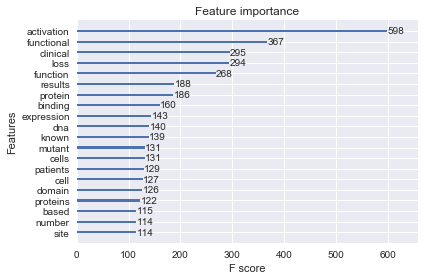

In [19]:
ax = xgb.plot_importance(model, height=0.2, max_num_features=20)

tfidf = pl2.named_steps['tfidf']
mi = pl2.named_steps['mi']
features = [tfidf.get_feature_names()[i] for i in mi.get_support(indices=True)]


f_index = [19, 49, 32, 62, 48, 80, 75, 28, 46, 42, 59, 64, 31, 70, 30, 43, 76, 27, 67, 88]
labels = [features[i] for i in f_index][::-1]
ax.set_yticklabels(labels)
plt.tight_layout()
plt.savefig('./input/importance_tfidf.pdf',dpi=300)

In [20]:
features

['10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '30',
 '50',
 'acid',
 'activation',
 'activity',
 'addition',
 'additional',
 'amino',
 'analysis',
 'analyzed',
 'associated',
 'based',
 'binding',
 'cancer',
 'cell',
 'cells',
 'clinical',
 'compared',
 'containing',
 'contrast',
 'control',
 'data',
 'described',
 'did',
 'different',
 'discussion',
 'dna',
 'domain',
 'effect',
 'expressed',
 'expression',
 'figure',
 'function',
 'functional',
 'gene',
 'genes',
 'high',
 'human',
 'identified',
 'important',
 'including',
 'increased',
 'independent',
 'known',
 'levels',
 'likely',
 'loss',
 'methods',
 'mutant',
 'mutation',
 'mutations',
 'number',
 'observed',
 'obtained',
 'patients',
 'performed',
 'presence',
 'present',
 'previously',
 'protein',
 'proteins',
 'reported',
 'respectively',
 'result',
 'results',
 'role',
 'sequence',
 'showed',
 'shown',
 'significant',
 'similar',
 'single',
 'site',
 'small